# Batch Effect Inspection and Feature Selection

This notebook focuses on:
1.  **Feature Selection:** Identifying top 2,000 Highly Variable Genes (HVGs) to improve signal-to-noise ratio.
2.  **Batch Effect Inspection:** Visualizing control (NC) cells to check for technical artifacts associated with experimental batches (`SampleID`).

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting settings
sc.settings.set_figure_params(dpi=100, frameon=False, vector_friendly=True, figsize=(5, 5))
sc.settings.verbosity = 3  # errors (0), warnings (1), info (2), hints (3)

print("Libraries imported.")

Libraries imported.


## 1. Load Data

We'll load the full dataset. Since we need to compute HVGs and run PCA/UMAP, loading into memory is preferred over backed mode for performance, given the dataset size (~45k cells) is manageable.

In [2]:
# Load the data
adata = sc.read_h5ad("obesity_challenge_1.h5ad")
print(f"Data loaded: {adata.n_obs} cells, {adata.n_vars} genes")

# Ensure gene names are unique
adata.var_names_make_unique()

Data loaded: 44846 cells, 11046 genes


## 2. Feature Selection (HVGs)

We will identify the top 2,000 highly variable genes (HVGs). This focuses the analysis on genes that carry biological signal rather than technical noise or housekeeping genes with constant expression.
X matrix is already log-normalized, so we can run `pp.highly_variable_genes`.

In [ ]:
# Identify Highly Variable Genes
# Using 'seurat' flavor which works on log-normalized data
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat')

print(f"Number of HVGs selected: {sum(adata.var['highly_variable'])}")

# Plot HVGs
import os
os.makedirs('figures', exist_ok=True)
sc.pl.highly_variable_genes(adata, show=False)
plt.savefig('figures/hvg_selection.png', dpi=300, bbox_inches='tight')
plt.show()

# Optional: Save HVG list for future use
hvg_list = adata.var_names[adata.var['highly_variable']].tolist()
with open("highly_variable_genes.txt", "w") as f:
    for gene in hvg_list:
        f.write(f"{gene}\n")

extracting highly variable genes


## 3. Batch Effect Inspection

We will focus on the Negative Control (NC) cells. In an ideal experiment, control cells should clustering together regardless of the sample they came from. Separation by `SampleID` indicates a batch effect.

In [4]:
# Create a subset of Negative Control (NC) cells
# Identify the column with perturbation info - we found it was 'gene' in the exploration
perturbation_col = 'gene' 
control_label = 'NC'

adata_nc = adata[adata.obs[perturbation_col] == control_label].copy()
print(f"Number of NC cells: {adata_nc.n_obs}")

# Check distribution of samples in NC
print("\nSample distribution in NC cells:")
print(adata_nc.obs['SampleID'].value_counts())

Number of NC cells: 8705

Sample distribution in NC cells:
SampleID
TF150_8    1138
TF150_1    1119
TF150_2    1097
TF150_5    1096
TF150_7    1096
TF150_6    1055
TF150_4    1053
TF150_3    1051
Name: count, dtype: int64


C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


computing PCA
    with n_comps=50


c:\Users\user\Downloads\Fatty-scRNAseq\.venv\Lib\site-packages\scanpy\preprocessing\_pca\__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


    finished (0:00:09)


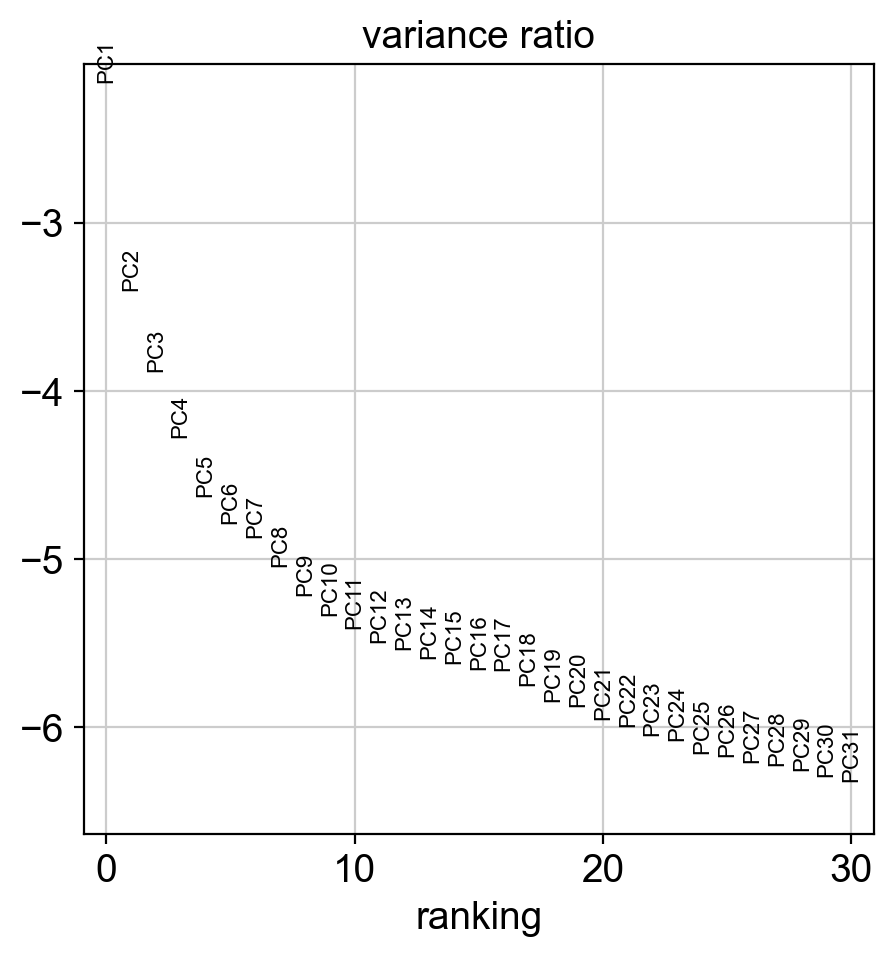

In [5]:
# Run PCA on the NC subset using ONLY the HVGs we calculated
# This is crucial for speed and relevance
sc.pp.scale(adata_nc, max_value=10)
sc.tl.pca(adata_nc, svd_solver='arpack', use_highly_variable=True)

# Plot PCA variance explained
sc.pl.pca_variance_ratio(adata_nc, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 40


c:\Users\user\Downloads\Fatty-scRNAseq\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:21)


<Figure size 1000x800 with 0 Axes>

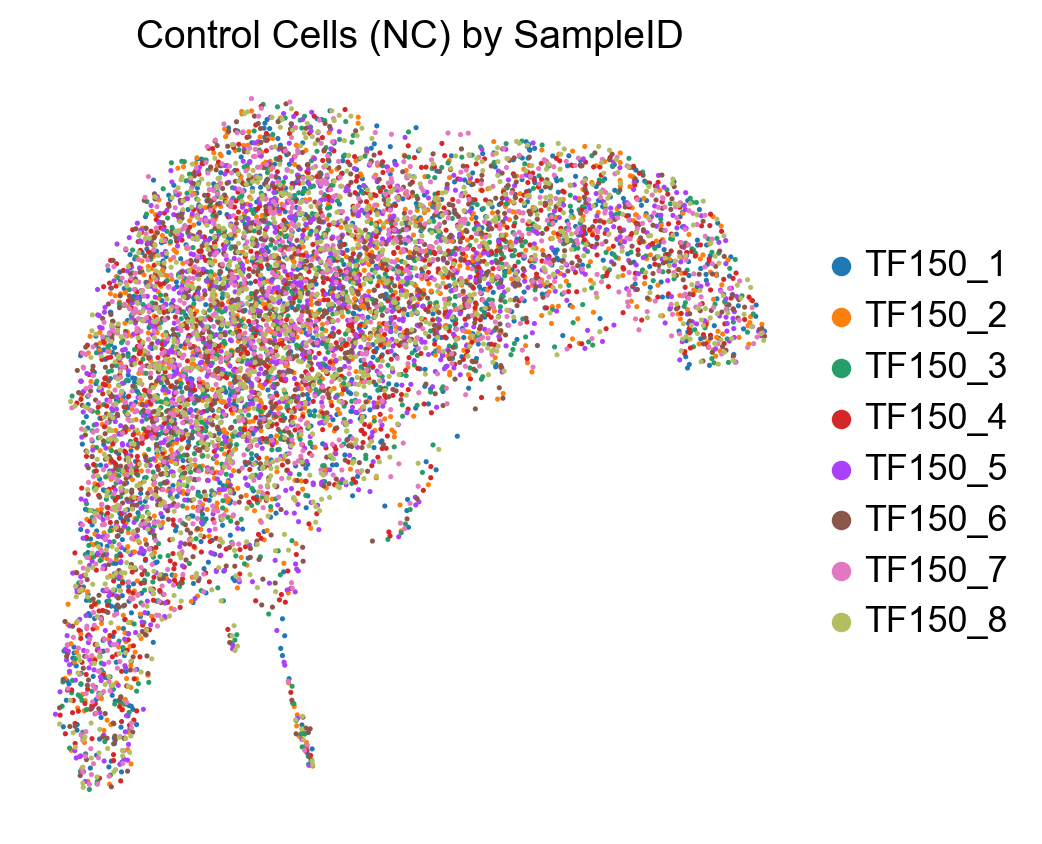

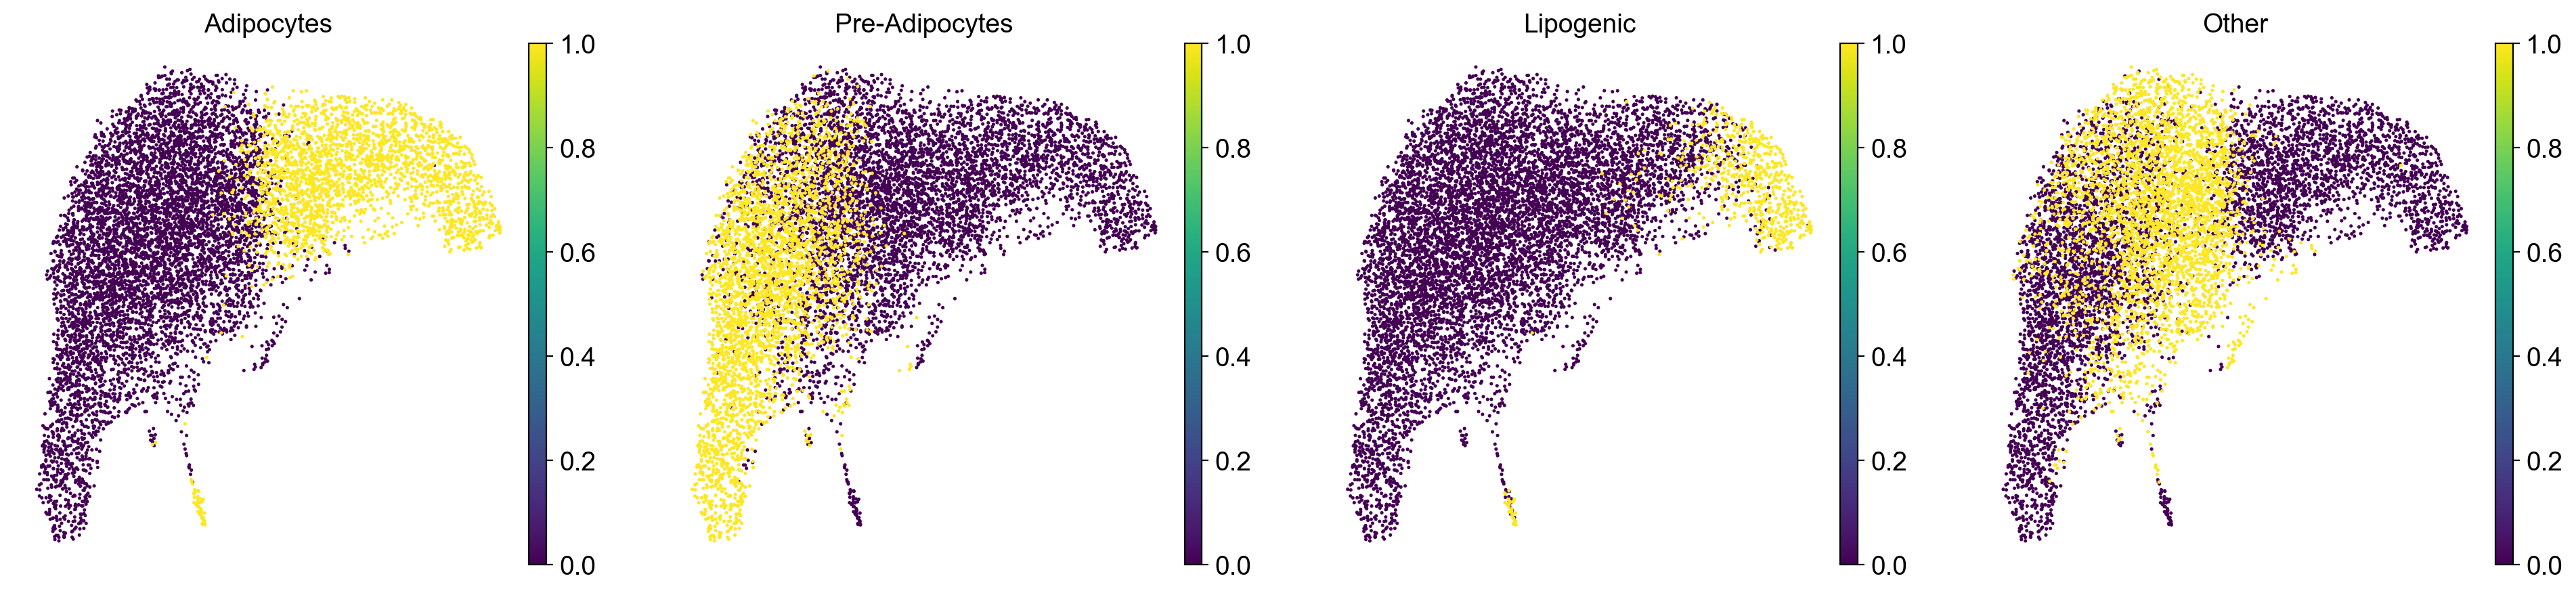

In [ ]:
# Compute Neighborhood Graph and UMAP
sc.pp.neighbors(adata_nc, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_nc)

# Prepare figures directory
import os
os.makedirs('figures', exist_ok=True)

# Visualize Batch Effect
plt.figure(figsize=(10, 8))
sc.pl.umap(adata_nc, color=['SampleID'], title='Control Cells (NC) by SampleID', show=False)
plt.savefig('figures/batch_effect_nc_umap.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualize biological covariates to compare (Cell states)
# If samples separate but also separate by cell state, it might be biological variation
plt.figure(figsize=(12, 10))
sc.pl.umap(adata_nc, color=['adipo', 'pre_adipo', 'lipo', 'other'], title=['Adipocytes', 'Pre-Adipocytes', 'Lipogenic', 'Other'], show=False)
plt.savefig('figures/cell_states_nc_umap.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Integration Strategy (Conditional)

If the plot above shows separation by `SampleID`, we should apply integration. `Harmony` is a fast and effective method for this type of data.

Below is the code template to run Harmony integration. You should execute this if you see strong batch effects.

In [ ]:
# Code for Harmony Integration (Uncomment to run if needed)

# try:
#     import scanpy.external as sce
#     print("Running Harmony integration...")
#     sce.pp.harmony_integrate(adata_nc, 'SampleID')
    
#     # Rerun UMAP on Harmony-corrected PCs
#     sc.pp.neighbors(adata_nc, use_rep='X_pca_harmony', n_neighbors=10, n_pcs=40)
#     sc.tl.umap(adata_nc)
    
#     # Plot corrected UMAP
#     plt.figure(figsize=(10, 8))
#     sc.pl.umap(adata_nc, color=['SampleID'], title='Control Cells (NC) after Harmony Correction')
#     plt.show()
# except ImportError:
#     print("scanpy.external not available or harmony-pytorch not installed.")
#     print("To install: pip install harmony-pytorch")